**Purpose:** Perform QC with SpotSweeper on a Stereo-seq Human PFC dataset. Only the 13 protein-coding mitochondrial genes were kept\
**Author:** Tamim Ahsan\
**Date:** 12 January 2026

# 1. Load packages and read data

In [1]:
# Packages
library(SpotSweeper)
library(scuttle)
library(anndataR)
library(SpatialExperiment)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

In [2]:
# Read data 
# StereoExpData was converted to AnnData object using stereopy package
# see https://github.com/tamim-ahsan/omics/blob/main/spatial_omics/transcriptomics/basic_workflows/Stereo-seq_sterepoy_conversion-to-anndata.ipynb
file_path <- "../stereo/GSM8330060_B02009F6_square.h5ad" 
adata <- read_h5ad(file_path)
adata

InMemoryAnnData object with n_obs × n_vars = 141494 × 43326
    obs: 'orig.ident', 'x', 'y'
    uns: 'bin_size', 'bin_type', 'key_record', 'merged', 'resolution', 'sn'
    obsm: 'spatial'

# 2. Create SpatialExperiment object

In [3]:
# Extract individual components
counts <- adata$X
rownames(counts) <- paste0("cell-", (rownames(counts)))
obs_data <- data.frame(sample_id = adata$obs$orig.ident)
rownames(obs_data) = paste0("cell-", (rownames(adata$obs)))
var_data <- adata$var
spatial_coords <- adata$obsm[["spatial"]]

In [4]:
# SpatialExperiment
spe <- SpatialExperiment(assays = list(counts = t(counts)),
                        rowData = var_data,
                        colData = obs_data,
                        spatialCoords = as.matrix(spatial_coords))
spatialCoordsNames(spe) <- c("x", "y")
spe

class: SpatialExperiment 
dim: 43326 141494 
metadata(0):
assays(1): counts
rownames(43326): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(0):
colnames(141494): cell-26843545617000 cell-26843545617200 ...
  cell-113172388253200 cell-113172388253250
colData names(1): sample_id
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):
spatialCoords names(2) : x y
imgData names(0):

# 3. Add spot-level QC metric values

In [5]:
# Filter out genes with low counts
# Keep the genes with at least 10 counts in total
# And were expressed in at least 100 cells
print(paste0("Number of genes before filtering ", nrow(spe)))
keep_genes <- (rowSums(counts(spe)) >= 10) & (rowSums(counts(spe) > 0) >= 100)
spe <- spe[keep_genes, ]
print(paste0("Number of genes after filtering ", nrow(spe)))

[1] "Number of genes before filtering 43326"
[1] "Number of genes after filtering 20362"


In [6]:
# Mitochondrial genes
is.mito <- rownames(spe)[grepl("^MT-", rownames(spe))]
length(is.mito)

[1] 36

In [7]:
# Among the 36 mitochondrial genes, only the 13 protein-coding genes are to be kept
mito_prot_genes <- c("MT-ND1", "MT-ND2", "MT-ND3", "MT-ND4", "MT-ND4L", 
                    "MT-ND5", "MT-ND6", "MT-CO1", "MT-CO2", "MT-CO3",
                    "MT-ATP6", "MT-ATP8", "MT-CYB")
mito_other_genes <- is.mito[!(is.mito %in% mito_prot_genes)]
length(mito_other_genes)

[1] 23

In [8]:
# Remove the other mitochondrial genes
keep_genes <- !(rownames(spe) %in% mito_other_genes)
spe <- spe[keep_genes, ]

In [9]:
# Remove cells with zero counts before adding the QC metric 
print(paste0("The number of spots before filtering = ", dim(spe)[2]))
spe <- spe[, colSums(counts(spe)) > 0]
print(paste0("The number of spots after filtering = ", dim(spe)[2]))

[1] "The number of spots before filtering = 141494"
[1] "The number of spots after filtering = 141491"


In [10]:
# Add per-cell (per-spot, in this case) QC metrics values to the spe object
spe <- addPerCellQC(spe,
                    subsets = list(Mito = mito_prot_genes))
colnames(colData(spe)) # check the names of the newly added columns

[1] "sample_id"             "sum"                   "detected"             
[4] "subsets_Mito_sum"      "subsets_Mito_detected" "subsets_Mito_percent" 
[7] "total"

# 4. Identify local outliers

In [11]:
# Local outlier detection -
# based on library size
spe <- localOutliers(
  spe,
  metric = "sum", # library size
  direction = "lower", # lower than a certain value (value of the metic - 3*z_score)
  log = TRUE, # log1p transformation is done
  n_neighbors = 48 # based on the value found in the SpotSweeper's github repo
)

# based on the number of detected genes
spe <- localOutliers(
  spe,
  metric = "detected",
  direction = "lower",
  log = TRUE,
  n_neighbors = 48
)

# based on the percentage of reads mapped to mitochondrial genes
spe <- localOutliers(
  spe,
  metric = "subsets_Mito_percent",
  direction = "higher",
  log = FALSE,
  n_neighbors = 48
)

In [12]:
# New columns x_outliers have been added the to the colData
colnames(colData(spe))

[1] "sample_id"                     "sum"                          
 [3] "detected"                      "subsets_Mito_sum"             
 [5] "subsets_Mito_detected"         "subsets_Mito_percent"         
 [7] "total"                         "sum_log"                      
 [9] "sum_outliers"                  "sum_z"                        
[11] "detected_log"                  "detected_outliers"            
[13] "detected_z"                    "subsets_Mito_percent_outliers"
[15] "subsets_Mito_percent_z"

In [13]:
# Combine all the outliers into a single column
spe$local_outliers <- as.logical(spe$sum_outliers) |
  as.logical(spe$detected_outliers) |
  as.logical(spe$subsets_Mito_percent_outliers)
table(spe$local_outliers)


 FALSE   TRUE 
140352   1139 

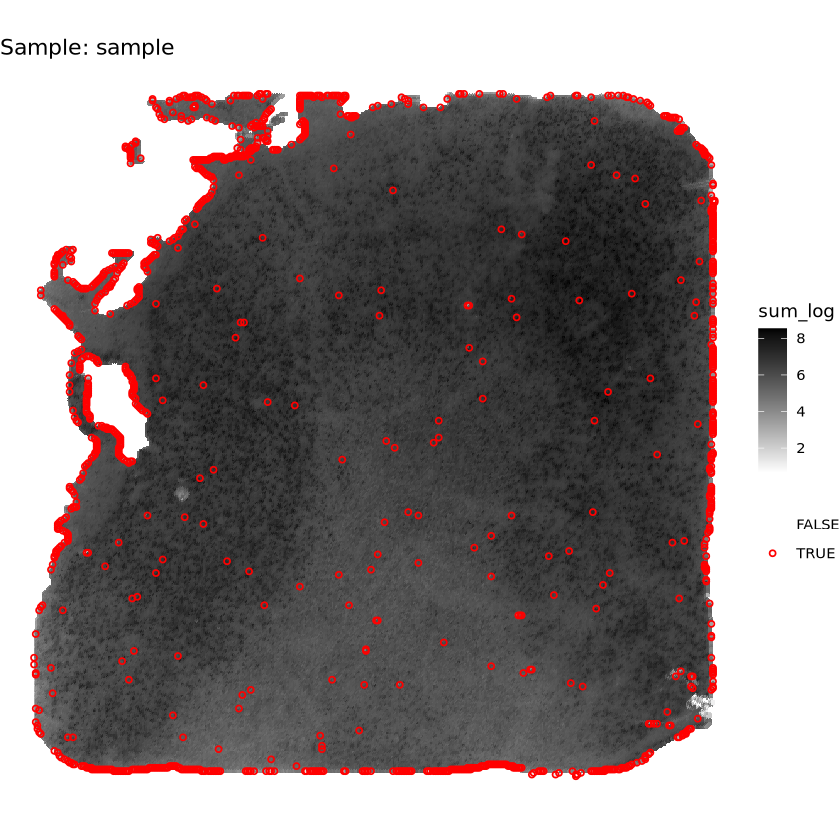

In [14]:
# Plot the outliers
plotQCmetrics(spe,
              metric = "sum_log",
              outliers = "local_outliers",
              point_size = 1.2,
              stroke = 0.75)

It was difficult to manually select a suitable threshold value for QC metrics for this dataset as the mitocohondrial ratio/percentage was relatively high and total counts were really confounded by spatial biology. So, very *generous* thresholds had to be used (see https://github.com/tamim-ahsan/omics/blob/main/spatial_omics/transcriptomics/basic_workflows/Stereo-Seq_stereopy_square-bin-workflow.ipynb) 

# 5. Find artifacts

In [15]:
# Find artifacts
spe <- findArtifacts(spe,
                    mito_percent = "subsets_Mito_percent",
                    mito_sum = "subsets_Mito_sum",
                    n_order = 5,
                    name = "artifact",
                    shape = "square")

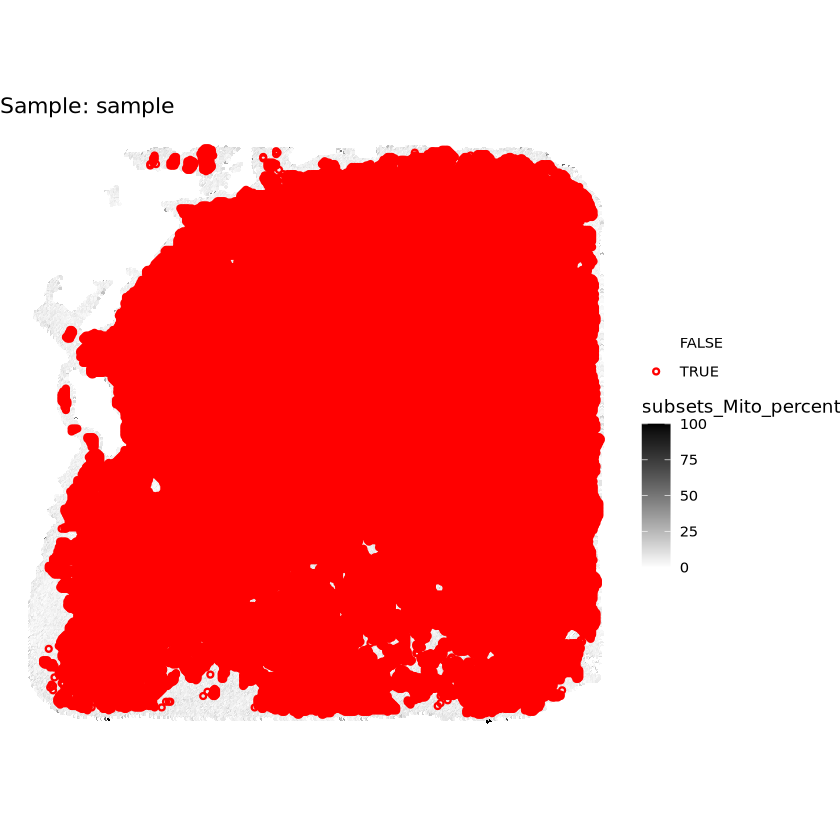

In [16]:
# Visualize hangnail artifacts
plotQCmetrics(
  spe,
  metric = "subsets_Mito_percent",
  outliers = "artifact",
  point_size = 1
)

In [17]:
# Number of "artifact" cells
table(spe$artifact)


 FALSE   TRUE 
 21163 120328 

**Commment:** Keeping only the protein-coding mitochondrial genes did not improve the outcome of this step. See the "QC_Stereo-seq_humanPFC_allMitoGenes.ipynb" notebook within this directory to see the outcomes when all mapped mitochondrial genes are used. 

# 6. Filter out low-quality spots

In [18]:
# Filter the low-quality cells/spots
# Filtering was done only on the basis of spot/cell-level QC and the regional QC did not seem to work
spe <- spe[, !spe$local_outliers]
spe

class: SpatialExperiment 
dim: 20339 140352 
metadata(0):
assays(1): counts
rownames(20339): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(1): subsets_Mito
colnames(140352): cell-27058293981000 cell-27058293981050 ...
  cell-112957639903150 cell-113172388253200
colData names(24): sample_id sum ... k120 artifact
reducedDimNames(1): PCA_artifacts
mainExpName: NULL
altExpNames(0):
spatialCoords names(2) : x y
imgData names(1): sample_id

In [19]:
sessionInfo()

R version 4.5.2 (2025-10-31)
Platform: x86_64-conda-linux-gnu
Running under: SUSE Linux Enterprise Server 15 SP6

Matrix products: default
BLAS/LAPACK: /nexus/posix0/MPI-psych/g/dept-binder/mpsmgp/ahsant/software/miniforge3/envs/tutor/lib/libopenblasp-r0.3.30.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] SpatialExperiment_1.20.0    anndataR_1.0.0             
 [3] scuttle_1.20.0              SingleCellExperiment_1.32.0
 [5] SummarizedExperiment_1.40.0 